In [5]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #visualisation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # to do the grid of plots
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, make_scorer,confusion_matrix # for evaluation
import itertools
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

***Anomaly detection:Predicting credit card fraud***

Author: Eleonora Tashkova


**Info for the dataset:**

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?datasetId=310
The dataset is provided by Kaggle and contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data could not be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amoun
t' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.Dataset and Preprocessing
The dataset is provided by Kaggle and contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data could not be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Basic info for this dataset:

In [2]:
df = pd.read_csv('creditcard.csv')
print(df.shape)

print("First 5 lines:")
print(df.head(5))

print("describe: ")
print(df.describe())

print("info: ")
print(df.info())

(284807, 31)
First 5 lines:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

We can see that we don't have any null values.

Visualising the data:

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

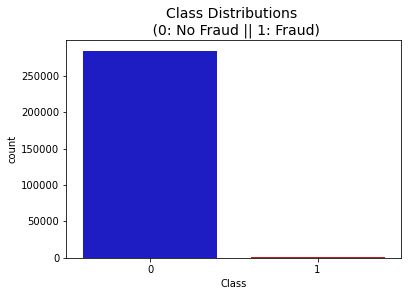

In [3]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

As we can see from this plot(and from the description of the dataset) the data is imbalanced, so we can't use a simple classifier.

Next, I'm visualising the distribution of the data by columns. This is important because for the statistical model used for predicting, we need features that follow a gaussian distribution.

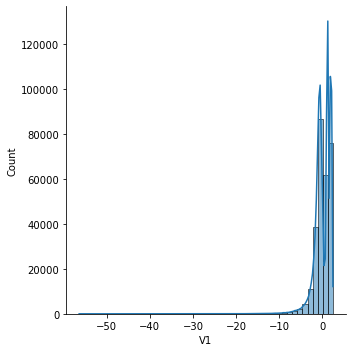

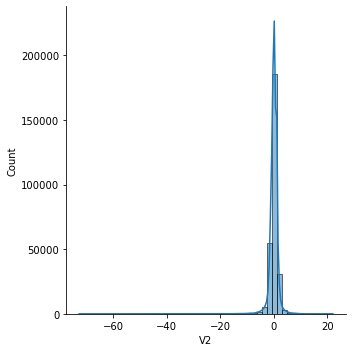

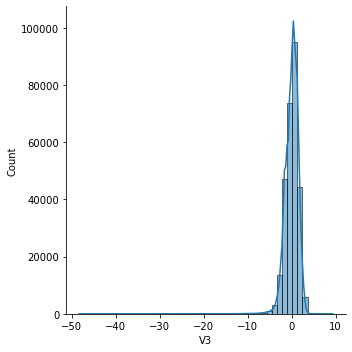

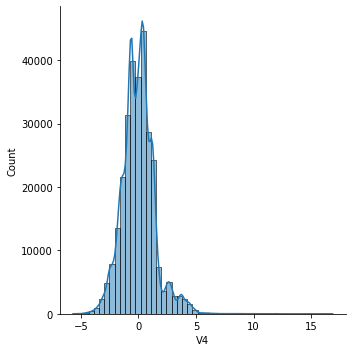

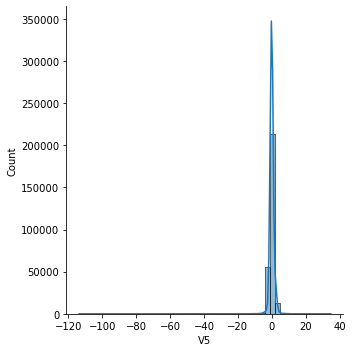

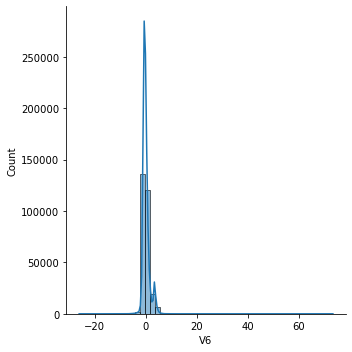

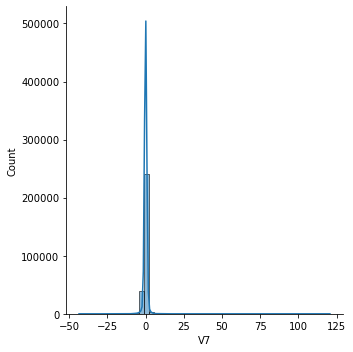

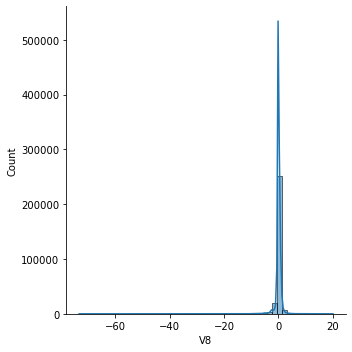

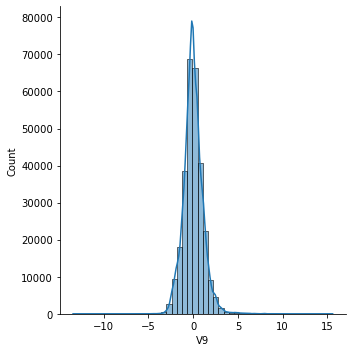

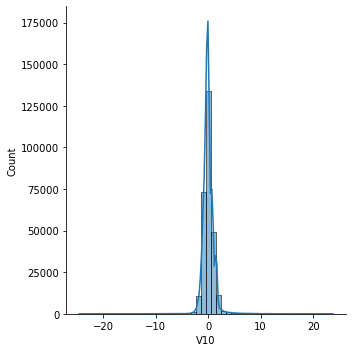

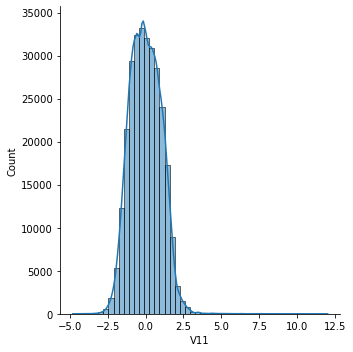

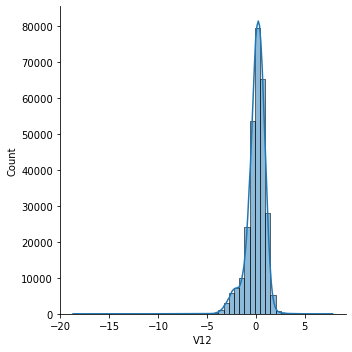

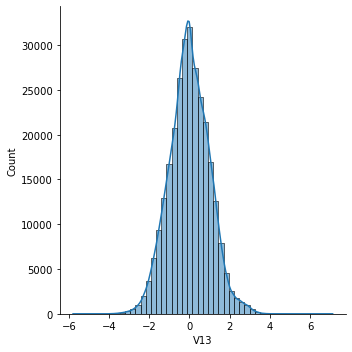

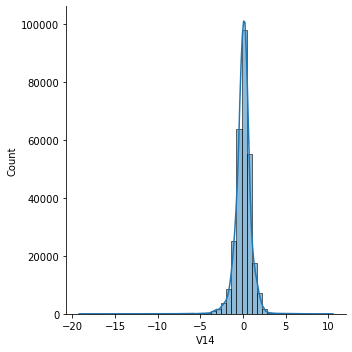

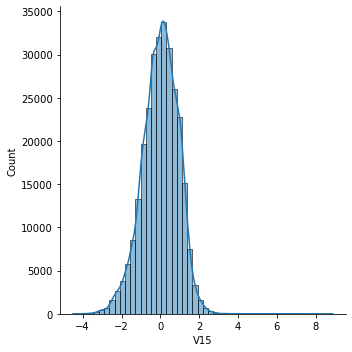

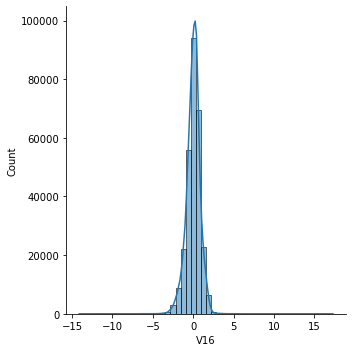

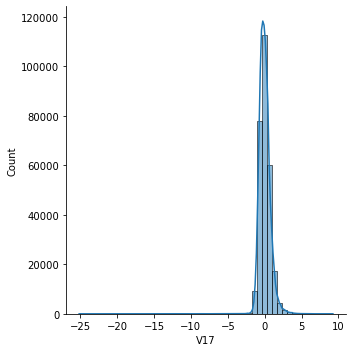

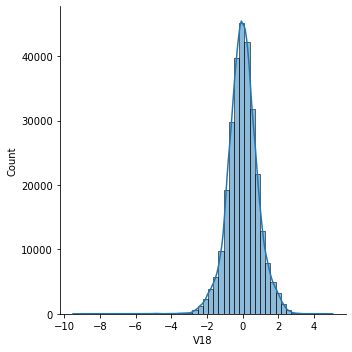

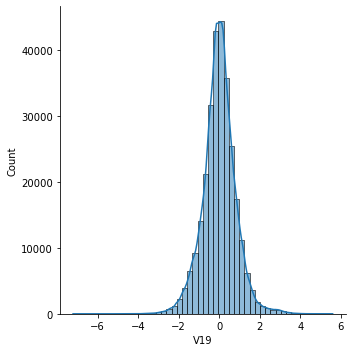

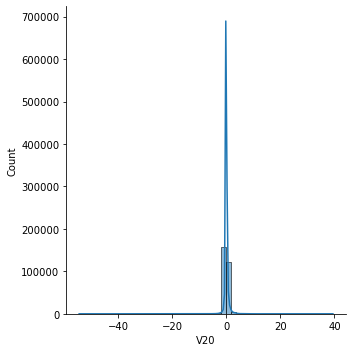

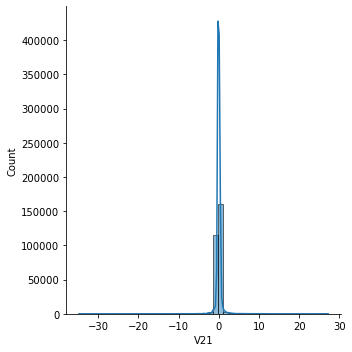

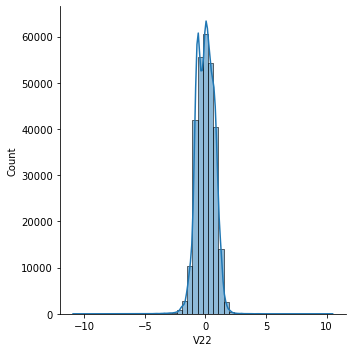

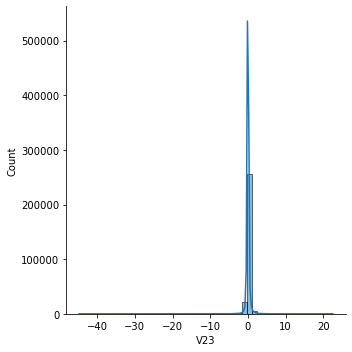

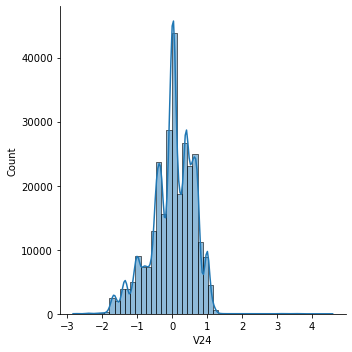

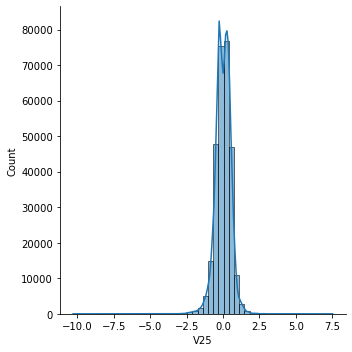

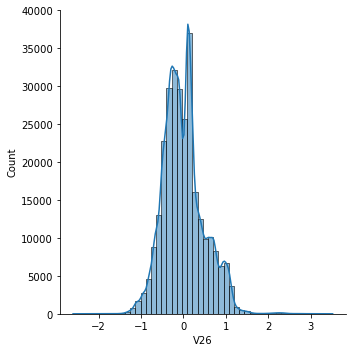

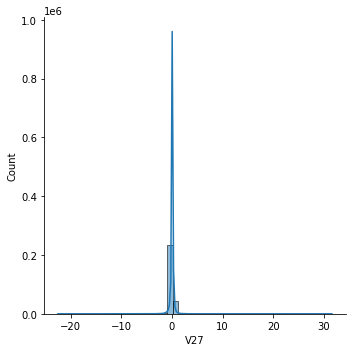

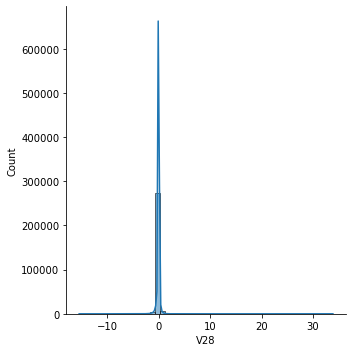

In [4]:

columns = df.iloc[:,1:29].columns
for n, col in enumerate(columns):
    sns.displot(data=df, x=col, bins=50,kde=True, fill=True ).set_titles(str(col))


These features look acceptable.

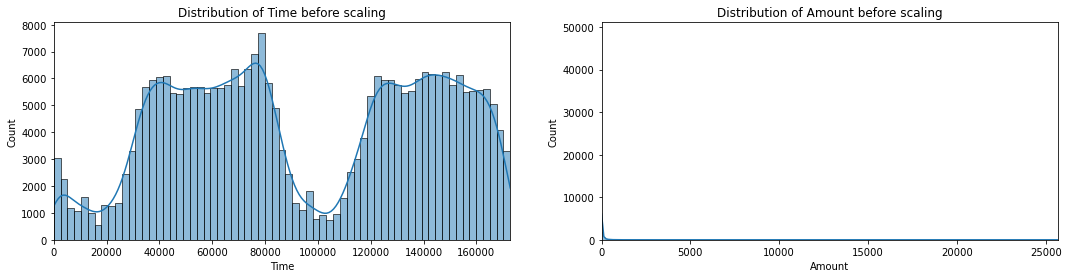

In [6]:
columns=["Time","Amount"]
fig, ax = plt.subplots(1, 2, figsize=(18,4))
for i,col in enumerate(columns):
    sns.histplot(data=df, x=col,kde=True,
    ax=ax[i], fill=True )
    ax[i].set_title("Distribution of " + columns[i] + " before scaling")
    ax[i].set_xlim([min(df[col]), max(df[col])])
plt.show()

We can see that these features are not scaled nor they follow a gaussian distribution.

**Anomaly detection**

For anomaly detection, I'm using the multivariate_normal function. This function assumes all features have a gaussian distribution, so I'm going to transform my Amount an Time features.

In [7]:

df['Amount'] = np.log(df['Amount'] + 1)
df['Time'] = np.log(df['Time'] + 1)

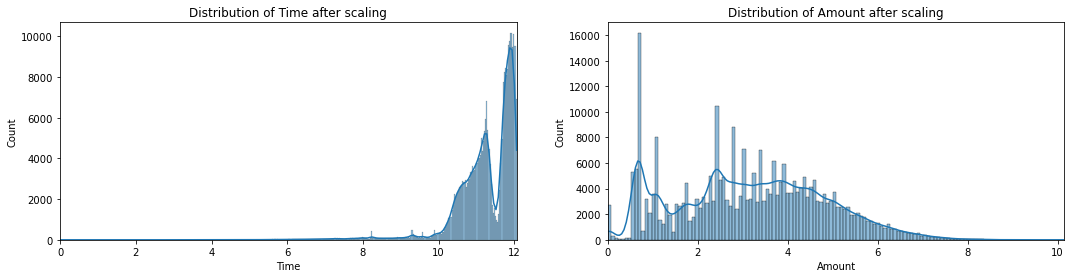

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
for i,col in enumerate(columns):
    sns.histplot(data=df, x=col,kde=True, ax=ax[i],fill=True )
    ax[i].set_xlim([min(df[col]), max(df[col])])
    ax[i].set_title("Distribution of " + columns[i] + " after scaling")
plt.show()

In [9]:

normal = df[df['Class'] == 0]
anomaly = df[df['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


**Train-test split**

I'm going to use 90% of the normal data for training and the rest will be split for testing and validation

In [10]:


train, normal_test, _, _ = train_test_split(normal,normal, test_size=.1, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion of anomaly in training set: %.4f\n' % train['Class'].mean())

print('Valid shape: ', valid.shape)
print('Proportion of anomaly in validation set: %.4f\n' % valid['Class'].mean())

print('Test shape:, ', test.shape)
print('Proportion of anomaly in test set: %.4f\n' % test['Class'].mean())


Train shape:  (255883, 31)
Proportion of anomaly in training set: 0.0000

Valid shape:  (14462, 31)
Proportion of anomaly in validation set: 0.0170

Test shape:,  (14462, 31)
Proportion of anomaly in test set: 0.0170



**Building the model**


I'm using the logpdf method for predicting because the values are small

In [11]:

mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

In [12]:
class0_pdf=model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values)
class1_pdf=model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values)

Visualising the predictions so we can determine the threshhold.

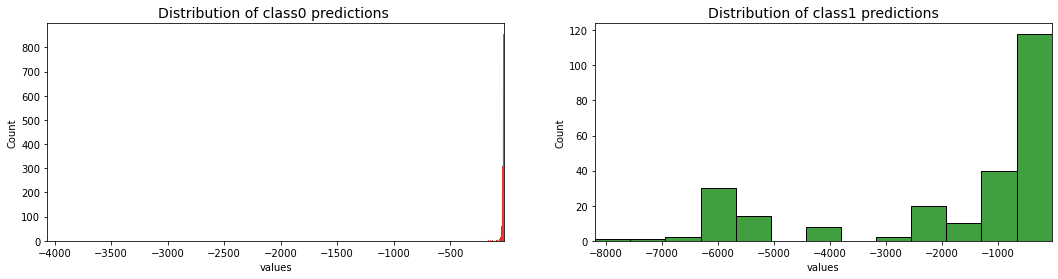

In [13]:

data=[class0_pdf,class1_pdf]
title=['Distribution of class0 predictions ','Distribution of class1 predictions']
fig, ax = plt.subplots(1, 2, figsize=(18,4))
colors=['r','g']
for i in range(2):
    sns.histplot(data[i], ax=ax[i], color=colors[i])
    ax[i].set_title(title[i], fontsize=14)
    ax[i].set_xlim([min(data[i]), max(data[i])])
    ax[i].set(xlabel="values")
plt.show()

We can see that most of the anomalies have a score under -500

In [14]:
tresholds = np.linspace(-500,-10, 100)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([accuracy_score(y_pred=y_hat, y_true=valid['Class'].values),
                 recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=1),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print("Accuracy score:")
print(scores[:, 0].max(), scores[:, 0].argmax())
print("F2 score:")
print(scores[:, 4].max(), scores[:, 4].argmax())

Accuracy score:
0.9939150878163463 41
F2 score:
0.7899022801302931 60


This is our validation F2 score

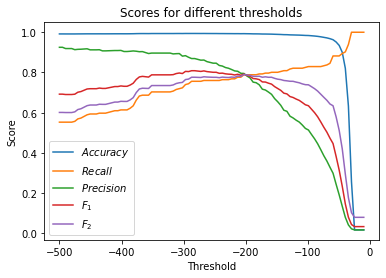

In [15]:

plt.plot(tresholds, scores[:, 0], label='$Accuracy$')
plt.plot(tresholds, scores[:, 1], label='$Recall$')
plt.plot(tresholds, scores[:, 2], label='$Precision$')
plt.plot(tresholds, scores[:, 3], label='$F_1$')
plt.plot(tresholds, scores[:, 4], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend()
plt.title("Scores for different thresholds")
plt.show()

In [16]:
final_tresh = tresholds[scores[:, 3].argmax()]
y_hat_test = (model.logpdf(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Accuracy Score: %.3f' % accuracy_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)

Final threshold: -287
Test Accuracy Score: 0.994
Test Recall Score: 0.789
Test Precision Score: 0.858
Test F2 Score: 0.802


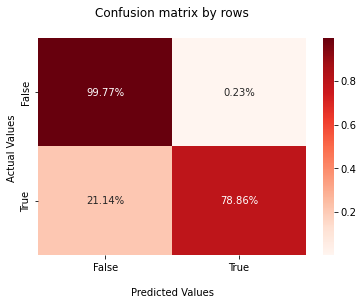

In [17]:
div=[[np.sum(cnf_matrix[0,:])],
     [np.sum(cnf_matrix[1,:])]]
ax = sns.heatmap(cnf_matrix/div, annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Confusion matrix by rows\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

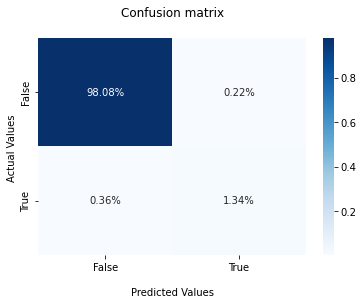

In [18]:
ax = sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Classifying using the SMOTE technique**

Using the SMOTE technique, artifitial samples will be created to build a better model.


In [70]:
df = pd.read_csv('creditcard.csv')
X = df.drop('Class',axis=1)
y = df['Class']

Spliting the data

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y, #the proportion of anomalies is persevered 
                                                    random_state=11)

In [77]:
print('X_train shape: ', X_train.shape)
print('Proportion of anomaly in training set: %.4f\n' % y_train.mean())


print('X_test shape:, ', X_test.shape)
print('Proportion of anomaly in test set: %.4f\n' % y_test.mean())

X_train shape:  (199364, 30)
Proportion of anomaly in training set: 0.0017

X_test shape:,  (85443, 30)
Proportion of anomaly in test set: 0.0017



I'm using a stratifiedKfold cross validation so all folds have the same proportion of class.

In [78]:
stratified_kfold = StratifiedKFold(n_splits=3)

Preparing a parameter grid for cross validation.

In [81]:
param_grid = {"classifier__max_depth": [3,5, None],
              "classifier__n_estimators":[3,5,10],
              "classifier__max_features": [5,6,7,8]}

Calculating several scores.

In [84]:
scoring = {"AUC":"roc_auc",
           "f1": make_scorer(fbeta_score, beta=1), 
           "f2":make_scorer(fbeta_score, beta=2),
           "precision":make_scorer(precision_score),
           "recall":make_scorer(recall_score)}

Building the pipeline.

In [79]:
pipeline = imbpipeline(steps = [
                                ['smote', SMOTE(random_state=11,sampling_strategy='minority')],
                                ['classifier', RandomForestClassifier()]],verbose=True)

Buildig the grid search.

In [85]:
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=stratified_kfold,
                           refit="f2",
                           return_train_score=True,
                           verbose=True)

Finding the best estimator.

In [101]:
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
results=grid_search.cv_results_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.9s
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.8s
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.8s
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.5s
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.6s
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   4.7s
[Pipeline] ............. (step 1 of 2) Processing smote, total=   0.4s
[Pipeline] ....

In [104]:
res=pd.DataFrame(results)

In [105]:
y_pred=grid_search.predict(X_test)

In [106]:

test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8077020465108381
Test score: 0.8422459893048128


This test score is better than the previous model's!


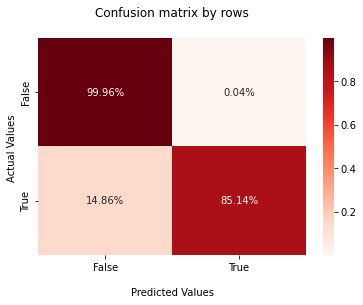

In [107]:
cnf_matrix = confusion_matrix(y_test, y_pred)
div=[[np.sum(cnf_matrix[0,:])],
     [np.sum(cnf_matrix[1,:])]]
ax = sns.heatmap(cnf_matrix/div, annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Confusion matrix by rows\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

85.14% of the existing anomalies are detected!

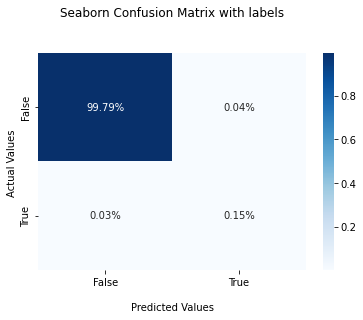

In [108]:

ax = sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Conclusion**



The our RandomForestClassifier found the anomalies better than the MultivariateGaussianDistribution, probably due to the fact that it is an ensamble learning method combined with grid search cross validation, so it was able to build and test different classifiers and find the best one.